In [1]:
import os
import sys

# Добавляем корневую директорию проекта в sys.path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../../")))

# Импортируем metrics из utils
from utils import metrics as mtc

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from sentence_transformers import (
    InputExample,
    SentencesDataset,
    SentenceTransformer,
    losses,
    util,
)
from torch.utils.data import DataLoader


c:\Users\filat\Documents\goprotect\.venv\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


# Моделирование SentenceTransformer

In [3]:
valid = pd.read_csv("../../data/preprocessed/ft LaBSE/valid.csv")
train = pd.read_csv("../../data/preprocessed/ft LaBSE/train.csv")
reference = pd.read_csv("../../data/preprocessed/ft LaBSE/reference.csv")


In [4]:
# Создаем пустой список для хранения пар
data_pairs = []

l = 0
# Добавляем пары (name, reference, 1)
for i, row1 in train.iterrows():
    for j, row2 in reference.iterrows():
        match = 1 if row1["school_id"] == row2["id"] else 0
        data_pairs.append((row1["final_phrases"], row2["reference"], match))

# Добавляем пары (name1, name2, 0) и (reference1, reference2, 0)
for i, row1 in train.iterrows():
    for j, row2 in reference.iterrows():
        if i != j:
            data_pairs.append((row1["final_phrases"], row2["reference"], 0))

for i, row1 in train.iterrows():
    for j, row2 in reference.iterrows():
        if i != j:
            data_pairs.append((row1["final_phrases"], row2["reference"], 0))


In [5]:
# Шаг 3: Инициализируйте модель и функцию потерь
model = SentenceTransformer("LaBSE")


In [6]:
# Преобразование данных в формат InputExample
train_data = [
    InputExample(texts=[item[0], item[1]], label=item[2]) for item in data_pairs
]


In [7]:
from sentence_transformers.util import is_datasets_available

In [8]:
is_datasets_available()

True

In [10]:
# Шаг 2: Создайте DataLoader
train_dataset = SentencesDataset(train_data, model)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=32)

# Шаг 3: Инициализируйте функцию потерь
train_loss = losses.SoftmaxLoss(
    model=model,
    sentence_embedding_dimension=model.get_sentence_embedding_dimension(),
    num_labels=2,
)

# Шаг 4: Обучите модель
model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    epochs=4,
    warmup_steps=100,
    show_progress_bar=True,
)


  0%|          | 0/62948 [00:00<?, ?it/s]

KeyboardInterrupt: 

### Преобразования в np.array

In [229]:
goal = "final_phrases"
x = valid[goal].to_numpy(dtype="str").flatten()
y = valid["school_id"].to_numpy(dtype="int").flatten()
reference_id = reference["id"].to_numpy(dtype="int").flatten()
reference_name = reference["reference"].to_numpy(dtype="str").flatten()

In [111]:
# Инициализируем модель
model = SentenceTransformer("LaBSE")

In [230]:
# Векторизация текстов
reference_embeddings = model.encode(reference_name, convert_to_tensor=True)
query_embeddings = model.encode(x, convert_to_tensor=True)

In [231]:
def find_matches_cosine(x_vec, reference_id, reference_vec, top_k=5, threshold=0.9):
    y_pred = []
    manual_review = []

    for x in x_vec:
        # Вычисляем косинусное сходство между x и всеми векторами reference_vec
        similarities = F.cosine_similarity(x.unsqueeze(0), reference_vec, dim=1)

        # Находим индексы top_k наиболее похожих векторов
        top_indices = torch.topk(similarities, k=top_k).indices
        max_similarity = torch.max(similarities).item()  # Нормализуем значение сходства

        if max_similarity < threshold:
            manual_review.append(x)
            top_matches = [(None, 0.0)] * top_k
        else:
            top_matches = [
                (reference_id[i], similarities[i].item()) for i in top_indices
            ]
            if len(top_matches) < top_k:
                top_matches += [(None, 0.0)] * (top_k - len(top_matches))

        y_pred.append(top_matches)

    return y_pred, manual_review

In [232]:
y_pred, manual_review = find_matches_cosine(
    query_embeddings, reference_id, reference_embeddings, top_k=5, threshold=0.67
)

metrics = mtc.calculate_metrics(y, y_pred, manual_review)
metrics

{'Accuracy@1': 0.403,
 'Accuracy@3': 0.562,
 'Accuracy@5': 0.614,
 'auto_error_rate': 0.597,
 'manual_processing_rate': 0.043,
 'general_error': 0.571}

In [233]:
# Массив значений threshold
threshold_values = np.linspace(0.1, 1.0, 25)

# Запуск функции и сбор метрик
metrics_list = []
for threshold in threshold_values:
    y_pred, manual_review = find_matches_cosine(
        query_embeddings,
        reference_id,
        reference_embeddings,
        top_k=5,
        threshold=threshold,
    )
    metrics = mtc.calculate_metrics(y, y_pred, manual_review)
    metrics_list.append(metrics)

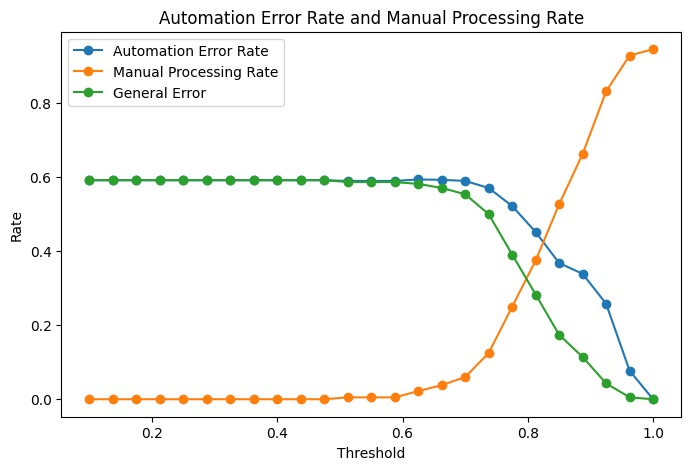

In [234]:
# Преобразование метрик в удобный формат для построения графика
auto_error_rate_values = [metrics["auto_error_rate"] for metrics in metrics_list]
manual_processing_rate_values = [
    metrics["manual_processing_rate"] for metrics in metrics_list
]
# general_spend_values = [metrics['general_spend'] for metrics in metrics_list]
general_error_values = [metrics["general_error"] for metrics in metrics_list]

# Определение общих границ для оси y
y_min = min(min(auto_error_rate_values), min(manual_processing_rate_values))
y_max = max(max(auto_error_rate_values), max(manual_processing_rate_values))

# Построение графика
plt.figure(figsize=(8, 5))

# plt.subplot(1, 2, 1)
plt.plot(
    threshold_values, auto_error_rate_values, marker="o", label="Automation Error Rate"
)
plt.plot(
    threshold_values,
    manual_processing_rate_values,
    marker="o",
    label="Manual Processing Rate",
)
plt.plot(threshold_values, general_error_values, marker="o", label="General Error")
plt.xlabel("Threshold")
plt.ylabel("Rate")
plt.title("Automation Error Rate and Manual Processing Rate")
plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(threshold_values, general_spend_values, marker='o', label='General Spend')
# plt.xlabel('Threshold')
# plt.ylabel('Money')
# plt.title('General Spend as Threshold')
# plt.legend()


# plt.tight_layout()
plt.show()

In [562]:
# Инициализируем модель
model = SentenceTransformer("sberbank-ai/sbert_large_nlu_ru")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/195 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/1.97k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/863 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.27k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.71M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

In [733]:
# Инициализируем модель
model = SentenceTransformer("LaBSE")

modules.json:   0%|          | 0.00/461 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/2.22k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/804 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/397 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/5.22M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.62M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

2_Dense/config.json:   0%|          | 0.00/114 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

In [734]:
reference_embed = model.encode(
    reference["final_phrases"].values, convert_to_tensor=True
)

In [735]:
train["final_phrases"][0]

'москва государственное бюджетное учреждение московская академия фигурного катания на коньках школа мечта'

In [736]:
train["final_phrases_wo_all_abbr"][0]

'москва школа мечта'

In [737]:
query_embed = model.encode(
    train["final_phrases_wo_all_abbr"][0], convert_to_tensor=True
)

In [738]:
train["school_id"][0]

102

In [739]:
reference[reference.id == 102]

,id,name,region,final_phrases,final_phrases_wo_unknown_abbr,final_phrases_wo_all_abbr,unknown_abbr
97,102,Мечта,Москва,мечта,мечта,мечта,[]


In [741]:
search_result = util.semantic_search(query_embed, reference_embed, top_k=5)

search_result

[[{'corpus_id': 97, 'score': 0.6021506786346436},
  {'corpus_id': 163, 'score': 0.5951200127601624},
  {'corpus_id': 230, 'score': 0.592901885509491},
  {'corpus_id': 101, 'score': 0.580794632434845},
  {'corpus_id': 178, 'score': 0.5796326994895935}]]

In [742]:
reference["final_phrases"].values[97]

'мечта'

In [743]:
reference["final_phrases"].values[163]

'спортивная школа'

In [744]:
reference["final_phrases"].values[230]

'спортивный клуб фигурного катания москвиной'

In [746]:
query_text = "школа мечта"

reference_texts = [
    "школа мечта",
    "школа",
    "мечта",
    "спортивная школа",
    "москва",
]

query_text_em = model.encode(query_text, convert_to_tensor=True)
reference_texts_em = model.encode(reference_texts, convert_to_tensor=True)

util.semantic_search(query_text_em, reference_texts_em, top_k=5)

[[{'corpus_id': 0, 'score': 1.0000001192092896},
  {'corpus_id': 1, 'score': 0.7317617535591125},
  {'corpus_id': 2, 'score': 0.7283006310462952},
  {'corpus_id': 3, 'score': 0.696265459060669},
  {'corpus_id': 4, 'score': 0.4366022050380707}]]

In [747]:
query_text = "мечта школа"

reference_texts = [
    "школа мечта",
    "школа",
    "мечта",
    "спортивная школа",
    "москва",
]

query_text_em = model.encode(query_text, convert_to_tensor=True)
reference_texts_em = model.encode(reference_texts, convert_to_tensor=True)

util.semantic_search(query_text_em, reference_texts_em, top_k=5)

[[{'corpus_id': 0, 'score': 0.9808474779129028},
  {'corpus_id': 1, 'score': 0.7296042442321777},
  {'corpus_id': 3, 'score': 0.7171162366867065},
  {'corpus_id': 2, 'score': 0.7049658894538879},
  {'corpus_id': 4, 'score': 0.42924055457115173}]]

Для реализации задачи обучение модели не требуется. Используем сразу валидационный датасет

In [61]:
valid = pd.read_csv("../../data/preprocessed/cosine/valid.csv")
reference = pd.read_csv("../../data/preprocessed/cosine/reference.csv")

In [62]:
valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184 entries, 0 to 183
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       184 non-null    object
 1   school_id  184 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 3.0+ KB


In [63]:
reference.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305 entries, 0 to 304
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         305 non-null    int64 
 1   reference  305 non-null    object
dtypes: int64(1), object(1)
memory usage: 4.9+ KB


### Преобразования в np.array

In [64]:
x = valid["name"].to_numpy(dtype="<U25").flatten()
y = valid["school_id"].to_numpy(dtype="int").flatten()
reference_id = reference["id"].to_numpy(dtype="int").flatten()
reference_name = reference["reference"].to_numpy(dtype="<U25").flatten()

### Функции расчета метрик и simple-предсказаний

In [65]:
def accuracy_top_k(y_true, y_pred, k):
    correct = 0
    valid_count = 0  # Счетчик для валидных предсказаний
    for true_id, pred_list in zip(y_true, y_pred):
        top_k_ids = [pred[0] for pred in pred_list[:k] if pred[0] is not None]
        if top_k_ids:
            valid_count += 1
            if true_id in top_k_ids:
                correct += 1
    return correct / valid_count if valid_count > 0 else 0


def check_top_1(true_values, predictions):
    result = []
    for pred_list, true in zip(predictions, true_values):
        if pred_list[0][0] == true:
            result.append(False)
        else:
            result.append(True)
    return result


def calculate_metrics(true_values, predictions, manual_review, cost=1):
    # Accuracy
    accuracy_top_1 = accuracy_top_k(true_values, predictions, 1)
    accuracy_top_3 = accuracy_top_k(true_values, predictions, 3)
    accuracy_top_5 = accuracy_top_k(true_values, predictions, 5)

    # Бизнес-метрика: процент ошибок автоматической обработки
    auto_error_rate = 1 - accuracy_top_1

    # Бизнес-метрика: доля данных, отправленных на ручную обработку данных
    manual_processing_rate = len(manual_review) / len(predictions)

    # manual_spend = len(manual_review) * cost

    # correction_spend = (len(true_values) - len(manual_review)) * cost * 1.5

    # general_error = (
    #     (len(true_values) - len(manual_review)) * auto_error_rate / len(true_values)
    # )

    general_error = (1 - manual_processing_rate) * auto_error_rate

    return {
        "Accuracy@1": round(accuracy_top_1, 3),
        "Accuracy@3": round(accuracy_top_3, 3),
        "Accuracy@5": round(accuracy_top_5, 3),
        "auto_error_rate": round(auto_error_rate, 3),
        "manual_processing_rate": round(manual_processing_rate, 3),
        "general_error": round(general_error, 3),
        # "manual_spend": manual_spend,
        # "correction_spend": correction_spend,
        # "general_spend": manual_spend+correction_spend,
    }

# Построение модели

In [66]:
# Векторизация текстов
vectorizer = TfidfVectorizer().fit(np.append(x, reference_name))
x_vec = vectorizer.transform(x)
reference_vec = vectorizer.transform(reference_name)

In [67]:
def find_matches_cosine(x_vec, reference_id, reference_vec, top_k=5, threshold=0.9):
    y_pred = []
    manual_review = []
    for x in x_vec:
        similarities = cosine_similarity(x, reference_vec).flatten()
        top_indices = similarities.argsort()[-top_k:][::-1]
        max_similarity = max(similarities)  # Нормализуем значение сходства
        if max_similarity < threshold:
            manual_review.append(x)
            top_matches = [(None, 0.0)] * top_k
        else:
            top_matches = [(reference_id[i], similarities[i]) for i in top_indices]
            if len(top_matches) < top_k:
                top_matches += [(None, 0.0)] * (top_k - len(top_matches))
        y_pred.append(top_matches)
    return y_pred, manual_review

In [68]:
# Массив значений threshold
threshold_values = np.linspace(0.1, 1.0, 10)

# Запуск функции и сбор метрик
metrics_list = []
for threshold in threshold_values:
    y_pred, manual_review = find_matches_cosine(
        x_vec, reference_id, reference_vec, top_k=5, threshold=threshold
    )
    metrics = calculate_metrics(y, y_pred, manual_review)
    metrics_list.append(metrics)

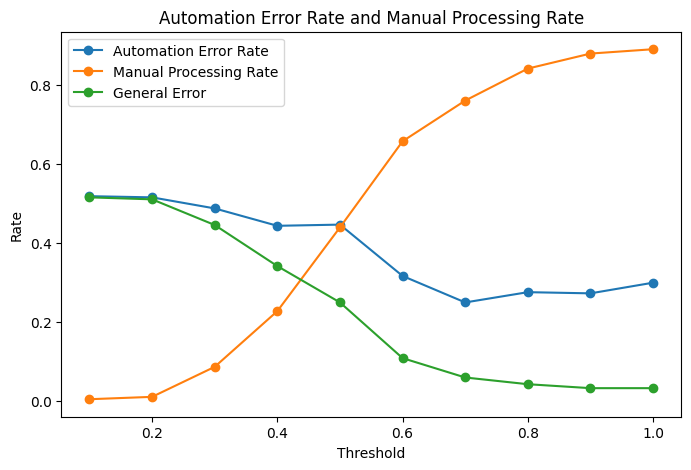

In [69]:
# Преобразование метрик в удобный формат для построения графика
auto_error_rate_values = [metrics["auto_error_rate"] for metrics in metrics_list]
manual_processing_rate_values = [
    metrics["manual_processing_rate"] for metrics in metrics_list
]
# general_spend_values = [metrics['general_spend'] for metrics in metrics_list]
general_error_values = [metrics["general_error"] for metrics in metrics_list]

# Определение общих границ для оси y
y_min = min(min(auto_error_rate_values), min(manual_processing_rate_values))
y_max = max(max(auto_error_rate_values), max(manual_processing_rate_values))

# Построение графика
plt.figure(figsize=(8, 5))

# plt.subplot(1, 2, 1)
plt.plot(
    threshold_values, auto_error_rate_values, marker="o", label="Automation Error Rate"
)
plt.plot(
    threshold_values,
    manual_processing_rate_values,
    marker="o",
    label="Manual Processing Rate",
)
plt.plot(threshold_values, general_error_values, marker="o", label="General Error")
plt.xlabel("Threshold")
plt.ylabel("Rate")
plt.title("Automation Error Rate and Manual Processing Rate")
plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(threshold_values, general_spend_values, marker='o', label='General Spend')
# plt.xlabel('Threshold')
# plt.ylabel('Money')
# plt.title('General Spend as Threshold')
# plt.legend()


# plt.tight_layout()
plt.show()

In [59]:
y_pred, manual_review = find_matches_cosine(
    x_vec, reference_id, reference_vec, top_k=5, threshold=0.25
)

metrics = calculate_metrics(y, y_pred, manual_review)
metrics

{'Accuracy@1': 0.503,
 'Accuracy@3': 0.674,
 'Accuracy@5': 0.766,
 'auto_error_rate': 0.497,
 'manual_processing_rate': 0.049,
 'general_error': 0.473}

Цель - не более 5% ручного разбора и не менее 95% точности автоматического разбора. Итоговая ошибка составит 4,7%.

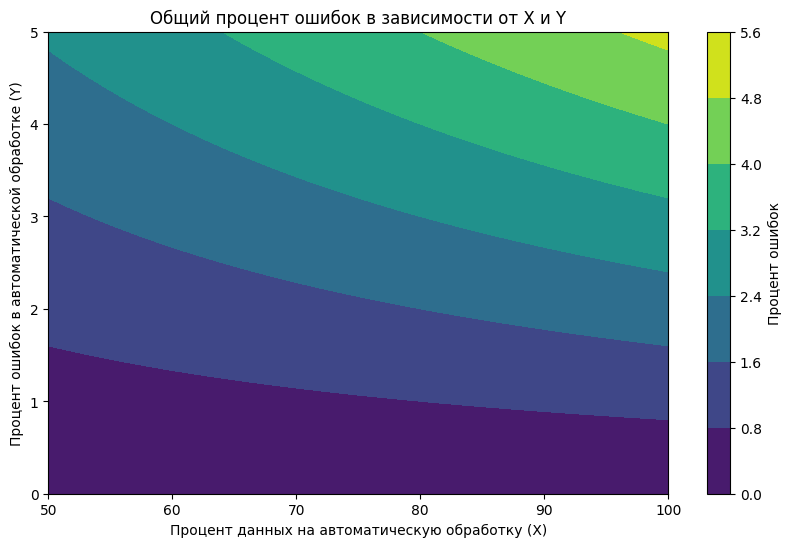

In [180]:
import matplotlib.pyplot as plt
import numpy as np

# Общее количество данных
total_data = 200

# Диапазоны значений для X и Y
X_values = np.linspace(0.5, 1, 100)  # 0% до 100%
Y_values = np.linspace(0, 0.05, 10)  # 0% до 10%

# Матрица для хранения процентов ошибок
error_percentages = np.zeros((len(X_values), len(Y_values)))

# Расчеты
for i, X in enumerate(X_values):
    for j, Y in enumerate(Y_values):
        automatic_data = total_data * X
        errors_in_automatic = automatic_data * Y
        total_errors_percentage = (errors_in_automatic / total_data) * 100
        error_percentages[i, j] = total_errors_percentage

# Создание графика
X_grid, Y_grid = np.meshgrid(
    X_values * 100, Y_values * 100
)  # Преобразование в проценты для осей
plt.figure(figsize=(10, 6))
contour = plt.contourf(X_grid, Y_grid, error_percentages.T, cmap="viridis")
plt.colorbar(contour, label="Процент ошибок")
plt.xlabel("Процент данных на автоматическую обработку (X)")
plt.ylabel("Процент ошибок в автоматической обработке (Y)")
plt.title("Общий процент ошибок в зависимости от X и Y")
plt.show()